# Imports and Data Setup

Little first thing about the data: <br>
I am using a slightly cleaned version of the data given, because <br>
I found that some of the entries had a spam label and entry within them. <br>
This resulted in some oddities later on so I cleaned those up and used the new dataset. 

In [8]:
import numpy as np 
import pandas as pd 
import plotly.express as px
import nltk.stem
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import os 
from os import path 
from PIL import Image
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA 
from sklearn.metrics import precision_score, f1_score, recall_score, accuracy_score
from sklearn.cluster import KMeans

dataf = pd.read_csv('./sms_spam_deep_cleaned.csv')

data = dataf.to_numpy()

X = data[:,1]
y = data[:,0]

-------------------------------
# **Problem #1: Binary Clustering**
Text Answer At End Of Section

## Code:

In [12]:
english_stemmer = nltk.stem.SnowballStemmer('english')
class StemmedTfidfVectorizer(TfidfVectorizer):
   def build_analyzer(self):
     analyzer = super(StemmedTfidfVectorizer, self).build_analyzer()
     return lambda doc: (english_stemmer.stem(w) for w in analyzer(doc))

vectorizer = StemmedTfidfVectorizer(min_df=1, stop_words='english')
X_train = vectorizer.fit_transform(X)

# map spam to 0 (negative) and ham to 1 (positive)
y_train = np.where(y == 'ham', 1, 0)

### Fitting KMeans

In [517]:
km = KMeans(n_clusters=2, init='random', n_init=10, random_state=200)
km.fit(X_train)

KMeans(init='random', n_clusters=2, random_state=200)

In [518]:
print(precision_score(y_train, km.labels_))
print(f1_score(y_train, km.labels_))
print(recall_score(y_train, km.labels_))
print(accuracy_score(y_train, km.labels_))

0.8658203125
0.909706546275395
0.9582792909641159
0.8343685300207039


### Fitting BIRCH Model

In [519]:
# from sklearn.mixture import GaussianMixture

# gm = GaussianMixture(n_components=2, init_params='random', n_init=1)
# dense_X = X_train.todense()

# dense_X

# gm.fit(dense_X)

from sklearn.cluster import Birch

birch = Birch(threshold=0.03, n_clusters=2)
birch.fit(X_train)


Birch(n_clusters=2, threshold=0.03)

In [520]:
print(precision_score(y_train, birch.labels_))
print(f1_score(y_train, birch.labels_))
print(recall_score(y_train, birch.labels_))
print(accuracy_score(y_train, birch.labels_))

0.9579459002535926
0.9687967514426159
0.9798962386511024
0.9450404667795972


## Answer:

Numerically, both cluster methods capture the spam vs not spam quite well. <br>

Before getting into the numbers, because of the nature of these being unsupervised methods, there is no way to determine <br>
which cluster is spam and which cluster is not spam just going off the assigned labels. <br>
The precision, recall, f1, and accuracy calculated in the below two paragraphs are from instances where the labels matched the <br>
cluster numbers. If that were not to be the case, the results would almost be flipped. Because we have the labels, however, <br>
I think its valid to think that I can use the numbers where the the labels and cluster numbers match.

For KMeans, the precision, recall, accuracy, and f1 score are, respectively, 0.8658, 0.9583, 0.8344, and 0.9097. <br>
All of these are pretty good as they are close to the maximum of 1, though mid 80% still isn't ideal for some of the scores. <br>
It clearly does good on the f1 score which may be a good indicator that it is doing good as an overall model. <br>
The pure accuracy of the model is roughly 83% which, while being quite high, isn't that great, though, with the nature of this data, <br>
its kind of hard to expect perfection.

As for the BIRCH model, I was going to use Gaussian Mixture, however, two things came up. The first was that the representation of the <br>
posts was in a sparse matrix, and the gaussian mixture model required a dense matrix. That was fine as its a simple .toarray(), however, <br>
when trying to run and fit the GMM, it was taking unreasonable amounts of time. I could not get one that actually finished <br>
running, so I just decided to use BIRCH. I thought maybe, even though its typically used alongside other models, <br>
it might run similarly to the GMM because its another distribution model. <br>
As for results from this, it performed better than KMeans pretty much over all. <br>
Precision, Recall, Accuracy, and F1 score were, respectively, 0.9579, 0.9799, 0.9450, and 0.9688. <br>
The accuracy is almost 10% higher than KMeans and F1 score 7% higher which shows a significant improvement overall. The recall is almost 100% <br>
and precision is similarily high. Its clear that for this dataset, the distribution models work a bit better than something more <br>
purely distance based like KMeans.








-------------------------

# **Problem #2: Clustering Quality**

## Finding The Clusters

In [523]:
for j in range(1, 100):
    ham_valid = 0
    spam_valid = 0

    nc = j
    km = KMeans(n_clusters=nc, init='random', random_state=4980)
    km.fit(X_train)

    for i in range(nc):
        x = y_train[(km.labels_ == i)]
        count_spam = (x == 0).sum()
        count_ham = (x == 1).sum()
        # print(f"Cluster {i}, Hams: {count_ham}, Spams: {count_spam}")
        if (count_spam < count_ham):
            if (count_spam < 5 and count_ham > 50):
                ham_valid += 1

        if (count_ham < count_spam):
            if (count_ham < 5 and count_spam > 50):
                spam_valid += 1
    
    if (ham_valid >= 2 and spam_valid >= 2):
        break

In [532]:
for i in range(0, nc):
    x = y_train[(km.labels_ == i)]
    count_spam = (x == 0).sum()
    count_ham = (x == 1).sum()
    print(f"Cluster {i}, Hams: {count_ham}, Spams: {count_spam}")

Cluster 0, Hams: 8, Spams: 4
Cluster 1, Hams: 18, Spams: 44
Cluster 2, Hams: 51, Spams: 8
Cluster 3, Hams: 15, Spams: 69
Cluster 4, Hams: 67, Spams: 11
Cluster 5, Hams: 60, Spams: 76
Cluster 6, Hams: 64, Spams: 0
Cluster 7, Hams: 89, Spams: 0
Cluster 8, Hams: 46, Spams: 3
Cluster 9, Hams: 1558, Spams: 181
Cluster 10, Hams: 40, Spams: 0
Cluster 11, Hams: 142, Spams: 2
Cluster 12, Hams: 65, Spams: 0
Cluster 13, Hams: 40, Spams: 0
Cluster 14, Hams: 127, Spams: 2
Cluster 15, Hams: 88, Spams: 0
Cluster 16, Hams: 89, Spams: 0
Cluster 17, Hams: 67, Spams: 9
Cluster 18, Hams: 49, Spams: 1
Cluster 19, Hams: 60, Spams: 4
Cluster 20, Hams: 176, Spams: 2
Cluster 21, Hams: 41, Spams: 0
Cluster 22, Hams: 0, Spams: 68
Cluster 23, Hams: 95, Spams: 2
Cluster 24, Hams: 43, Spams: 0
Cluster 25, Hams: 123, Spams: 4
Cluster 26, Hams: 109, Spams: 0
Cluster 27, Hams: 58, Spams: 0
Cluster 28, Hams: 33, Spams: 0
Cluster 29, Hams: 94, Spams: 2
Cluster 30, Hams: 159, Spams: 0
Cluster 31, Hams: 39, Spams: 0
Clust

### Cluster Number Explanation

The above code cell will find the smallest number of components <br>
that creates 2 clusters where spam is below 5 and ham is above 50 <br>
and 2 clusters where ham is below 5 and spam is above 50. 

## Part A: WordClouds, Stats, and Example Messages
Stats and example messages for each wordcloud are below the wordcloud.

### Spam Clusters

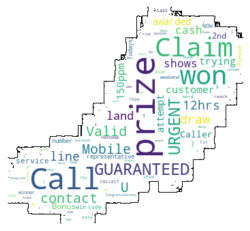

cluster size: 68
percent spam: 1.0
URGENT! Your Mobile number has been awarded with a £2000 prize GUARANTEED. Call 09061790121 from land line. Claim 3030. Valid 12hrs only 150ppm
449050000301 You have won a £2000 price! To claim call 09050000301.
URGENT! We are trying to contact U. Todays draw shows that you have won a £800 prize GUARANTEED. Call 09050001295 from land line. Claim A21. Valid 12hrs only


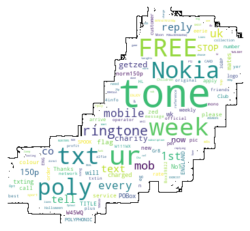

cluster size: 52
percent spam: 1.0
Bought one ringtone and now getting texts costing 3 pound offering more tones etc
FREE for 1st week! No1 Nokia tone 4 ur mob every week just txt NOKIA to 8007 Get txting and tell ur mates www.getzed.co.uk POBox 36504 W45WQ norm150p/tone 16+
Get the official ENGLAND poly ringtone or colour flag on yer mobile for tonights game! Text TONE or FLAG to 84199. Optout txt ENG STOP Box39822 W111WX £1.50


In [541]:
spam_cluster_ids = [22, 38]
ham_cluster_ids = [44, 45, 47]

# https://amueller.github.io/word_cloud/auto_examples/masked.html 
# get data directory (using getcwd() is needed to support running example in generated IPython notebook)
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

# read the mask image
spam_mask = np.array(Image.open(path.join(d, "spam.jpg")))
ham_mask = np.array(Image.open(path.join(d, "ham.jpg")))

for cluster_id in spam_cluster_ids:
    matching_indices = (km.labels_== cluster_id)
    all_text = " ".join(txt for txt in X[matching_indices.nonzero()[0]])
    word_cloud1 = WordCloud(collocations = False, background_color = 'white',
                            width = 2048, height = 2048, mask=spam_mask,
                            contour_width=1, contour_color='black').generate(all_text)
    plt.imshow(word_cloud1, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    word_cloud1.to_file(path.join(d, "spam" + str(cluster_id) + ".png"))
    print("cluster size:",X[matching_indices].size)
    print("percent spam:",(y_train[matching_indices] == 0).sum() / matching_indices.sum())
    lines = X[matching_indices]
    indices = np.random.choice(lines.shape[0], 3, replace=False)
    for index in indices:
        print(lines[index])

### Ham Clusters

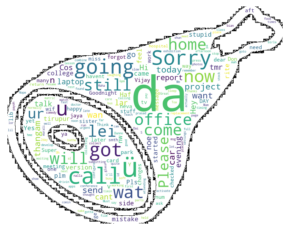

cluster size:  100
percent spam: 0.0
No da if you run that it activate the full version da.
Hi dude hw r u da realy mising u today
Sorry da. I gone mad so many pending works what to do.


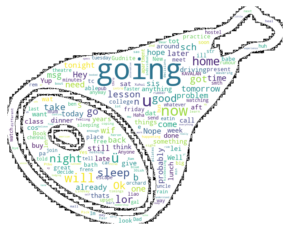

cluster size:  113
percent spam: 0.008849557522123894
Gudnite....tc...practice going on
Hey gals.. Anyone of u going down to e driving centre tmr?
Err... Cud do. I'm going to  at 8pm. I haven't got a way to contact him until then.


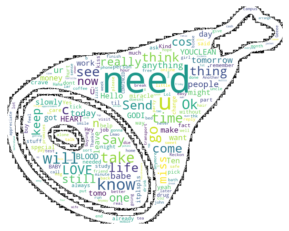

cluster size:  107
percent spam: 0.009345794392523364
Did u find out what time the bus is at coz i need to sort some stuff out.
I need details about that online job.
Hey chief can you give me a bell when you get this. Need to talk to you about this royal visit on the 1st june. 


In [528]:
for cluster_id in ham_cluster_ids:
    matching_indices = (km.labels_== cluster_id)
    all_text = " ".join(txt for txt in X[matching_indices.nonzero()[0]])
    word_cloud1 = WordCloud(collocations = False, background_color = 'white',
                            width = 2048, height = 2048, mask=ham_mask,
                            contour_width=1, contour_color='black').generate(all_text)
    plt.imshow(word_cloud1, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    word_cloud1.to_file(path.join(d, "ham" + str(cluster_id) + ".png"))
    print("cluster size: ",X[matching_indices].size)
    print("percent spam:",(y_train[matching_indices] == 0).sum() / matching_indices.sum())
    lines = X[matching_indices]
    indices = np.random.choice(lines.shape[0], 3, replace=False)
    for index in indices:
        print(lines[index])
    

## Part B: Spam With Ham? Ham With Spam?

In [534]:
# cluster 5 spam with ham 
cspam_indices = (km.labels_== 23)

cspam_labels = y_train[cspam_indices]
cspam_messages = X[cspam_indices]

print("Spam in Ham:", cspam_messages[cspam_labels == 0][0])
print("Spam in Ham:", cspam_messages[cspam_labels == 0][1])
print()

# cluster 13 ham with spam
cham_indices = (km.labels_ == 3)

cham_labels = y_train[cham_indices]
cham_messages = X[cham_indices]

print("Ham in Spam:",cham_messages[cham_labels == 1][0])
print("Ham in Spam:",cham_messages[cham_labels == 1][1])
print("Ham in Spam:",cham_messages[cham_labels == 1][3])

Spam in Ham: Call from 08702490080 - tells u 2 call 09066358152 to claim £5000 prize. U have 2 enter all ur mobile & personal details @ the prompts. Careful!
Spam in Ham: tells u 2 call 09066358152 to claim £5000 prize. U have 2 enter all ur mobile & personal details @ the prompts. Careful!

Ham in Spam: Yup next stop.
Ham in Spam: It will stop on itself. I however suggest she stays with someone that will be able to give ors for every stool.
Ham in Spam: Stop the story. I've told him i've returned it and he's saying i should not re order it.


## Part C: Spam Generation

For the texts below, I believe they will fall into cluster 9, 38, 44, and 45 respectively based on their contents. <br>
I expect these to be close to one fo the clusters because I used a lot of the words from the word cloud. <br>
That is a lot of what the distance is based on, so I hope using them will lead to close messages. <br>
However, a lot of these are very common scam words too so its possible that they end up in one of the other <br>
clusters that the KMeans identified. 

In [552]:
text_c9 = "Urgent!! You have won a PRIZE! you have been selected to receive a BRAND NEW mobile! Call and speak to the representative to receive your prize today!"
text_c38 = 'Ringtone! ur free nokia now! reply for free and text txt ur operator to apply! poly 150p'
text_c44 = "u still going to da office today? u got to call will the report now, please. sorry, got to go home for da project."
text_c45 = "going home, mee u later. driving mum from pub. will sleep good ok? lor already got home anyway. probably will bath tomorrow. gudnite night"

### Verify Not In Dataset

In [553]:
assert((X == text_c9).sum() == 0)
assert((X == text_c38).sum() == 0)
assert((X == text_c44).sum() == 0)
assert((X == text_c45).sum() == 0)

print("All assertions passed!")

All assertions passed!


### Distance From Centers

In [554]:
texts = np.array([text_c9, text_c38, text_c44, text_c45])

newx = np.append(X, texts)
newx[-4:]

newx = vectorizer.fit_transform(newx)
tx = newx[-4:,:]

km.predict(tx)

array([22, 38, 44, 45])

As we can see from above, the text that I thought would be in each cluster, are in fact in those same clusters. <br>
For each of the texts, the reason that I thought they would be close to the cluster is that I used a lot of <br>
words from the word clouds, especially the words that were big, and thus showed up a lot in the cluster. <br>
Doing so made me confident that the distance to that cluster would be closer than to others, though, <br>
they easily could have been in another cluster if they were just slightly not representative enough of that cluster. <br>
An example of this happening is the text that I thought would be in cluster 45. Initially, I didn't have the second <br>
to last sentence included, but it got classified into cluster 11, so I added those words and it got into 45. <br>
Clearly cluster 45 and 11 are pretty close to each other, or cluster 45 has a lot of words that are used often in other documents. 

---------------------------------
# **Problem #3: PCA**

## Part A: Graph PCA

In [555]:
pca = PCA(n_components=3)
pc = pca.fit_transform(X_train.toarray())

pc_df = pd.DataFrame(data = pc, columns = ['PC1', 'PC2', 'PC3'])
pc_df['Cluster'] = y
pc_df['ID'] = np.arange(0, len(y))
pc_df

fig = px.scatter_3d(pc_df, x="PC1", y="PC2", z="PC3", color = 'Cluster',hover_data=["ID"])
fig.show()

## Part B: Spam On The Run
Using the graph above, I identified a couple spam points that were far away from the others. <br>
Those spam id's are 2639, 3187, and 1555. Those messages are shown below in addition to typical spam for comparison.

In [556]:
print("Atypical Spam:")
print(X[2647])
print(X[3196])
print(X[1559])

print()
print("Typical Spam:")
print(X[4251])
print(X[4037])
print(X[2398])

Atypical Spam:
How come it takes so little time for a child who is afraid of the dark to become a teenager who wants to stay out all night?
Sorry I missed your call let's talk when you have the time. I'm on 07090201529
500 free text msgs. Just text ok to 80488 and we'll credit your account

Typical Spam:
Welcome to UK-mobile-date this msg is FREE giving you free calling to 08719839835. Future mgs billed at 150p daily. To cancel send go stop to 89123
FREEMSG: Our records indicate you may be entitled to 3750 pounds for the Accident you had. To claim for free reply with YES to this msg. To opt out text STOP
U have won a nokia 6230 plus a free digital camera. This is what u get when u win our FREE auction. To take part send NOKIA to 83383 now. POBOX114/14TCR/W1 16


The first three above examples may be seen as atypical by PCA because of how somewhat normal they seem, <br>
at least when compared to the three other spam messages from the spam cluster. <br>
They use a few words that spam messages might use such as call an text and account, <br>
but they also use a lot of normal words and even the first two sound like they could be normal messages. <br>
The variance between them and the other present spam messages may be quite high, leading to PCA putting them in a different area. 

## Part C: Gotta Catch it All (Variance)

As can be seen below, there are 6864 features in the dataset.

In [557]:
print(f"Total Features: {X_train.shape[1]}")

Total Features: 6864


As can be seen below, the number of components to get a total explained variance <br>
of greater than 50% is >= 322 components. In order to find this number, <br>
In the end, it comes out to be roughly 5% of the total possible components <br>
are needed to get the explained variance to be greater than 50%.

In [558]:
pca = PCA(n_components=600)
X_trans = pca.fit_transform(X_train.toarray())

total = 0
for i,val in enumerate(pca.explained_variance_ratio_):
    total += val
    if total >= 0.5:
        print(i + 1) 
        break

322


In [559]:
print(total)

0.5000992768108803


The graph below goes from 1 to 600 components to give a better idea of where the explained <br>
variance actually crosses the 50% mark and give a better idea of what # of components that is.

In [560]:
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
)

--------------------------------
# **Problem #4: Dimensionality Reduction and Classification**

## Splitting Test and Train

In [561]:
p4_train_x, p4_test_x, p4_train_y, p4_test_y = train_test_split(
    X_train, y_train, test_size=0.33, random_state=10497109
)

pca = PCA(n_components=10)
X_trans = pca.fit_transform(X_train.toarray())

p4_train_tx, p4_test_tx, p4_train_ty, p4_test_ty = train_test_split(
    X_trans, y_train, test_size=0.33, random_state=10497109
)

## 1-Nearest-Neighbor: Fully Vectorized

In [562]:
%%time
knc = KNeighborsClassifier(n_neighbors=1)
knc.fit(p4_train_x, p4_train_y)

p4_preds = knc.predict(p4_test_x)

print("precision:",precision_score(p4_test_y, p4_preds))
print("recall:",recall_score(p4_test_y, p4_preds))
print("accuracy:",accuracy_score(p4_test_y, p4_preds))
print("f1:",f1_score(p4_test_y, p4_preds))

precision: 0.9393939393939394
recall: 1.0
accuracy: 0.9441277080957811
f1: 0.96875
CPU times: total: 125 ms
Wall time: 103 ms


## 1-Nearest-Neighbor: Reduced Dimensions

In [563]:
%%time
knc = KNeighborsClassifier(n_neighbors=1)
knc.fit(p4_train_tx, p4_train_ty)

p4_preds = knc.predict(p4_test_tx)

print("precision:",precision_score(p4_test_ty, p4_preds))
print("recall:",recall_score(p4_test_ty, p4_preds))
print("accuracy:",accuracy_score(p4_test_ty, p4_preds))
print("f1:",f1_score(p4_test_ty, p4_preds))

precision: 0.979564930784443
recall: 0.978275181040158
accuracy: 0.9635119726339795
f1: 0.9789196310935442
CPU times: total: 78.1 ms
Wall time: 70 ms


## Comparison

To start, I chose to reduce the dataset down to 10 components for two reasons: <br>
1) It was a decently small number, so the KMeans will run a bit faster on it. <br>
2) I initially decided to keep more variance because I thought perhaps that would <br>
speed up the classification while keeping accuracy, however, I found that at lower <br>
dimensions, the classification got better on the training set than at higher dimensions, <br>
so I decided to choose 10. This is likely because there was a lot of noise in the original <br>
dataset, and reducing the dimensions took out some of the noise, resulting in better classification. <br>

As for the comparison, we can refer to the precision, recall, accuracy, f1, and clock/wall times in the <br>
above two code cells. When looking at the results, we can see that the reduced-dimension dataset is higher in almost <br>
every one of the metrics. The only metric that it scores lower in is recall. It has a higher classification accuracy <br>
overall and also has a higher f1 score than the full dataset. This is significant because it also takes roughly 40ms less <br>
time than the full dataset KNeighborsClassifier does. Of course thats not factoring in the time it took to reduce the <br>
dataset down to those dimensions, but that only has to happen once. <br>
It is clear to see that the reduction in dimension of the dataset can lead to even better classification through <br>
noise removal, as long as the dimensions being reduced to are chosen properly, as if you reduce dimensions too much, <br>
you could get to the case where you lose too much important information and variation and can't capture the classification <br>
as well. 

-----------------------
# **Problem #5: Spam Classification**

In [26]:
p5_X = TfidfVectorizer(min_df=0, stop_words='english').fit_transform(X)
p5_y = y_train.copy()

pca = PCA(n_components=900)
p5_Xt = pca.fit_transform(p5_X.toarray())

print(p5_Xt.shape)

p5_train_x, p5_test_x, p5_train_y, p5_test_y = train_test_split(
    p5_Xt, p5_y, test_size=0.33, random_state=10497109
)


(5313, 900)


In [29]:
layers = [
    128,
    256,
    128,
]

clf = MLPClassifier(
    random_state=4980,
    hidden_layer_sizes=np.array(layers),
    activation='relu',
    learning_rate='adaptive',
    # solver='lbfgs',
    alpha=0.0065
).fit(p5_train_x, p5_train_y)

In [30]:
p5_preds = clf.predict(p5_test_x)

print("precision:",precision_score(p5_test_y, p5_preds))
print("recall:",recall_score(p5_test_y, p5_preds))
print("accuracy:",accuracy_score(p5_test_y, p5_preds))
print("f1:",f1_score(p5_test_y, p5_preds))

precision: 0.9837133550488599
recall: 0.9940750493745886
accuracy: 0.9806157354618016
f1: 0.9888670595939751


## Design Decisions: 

I hope this was okay, the writeup did say just to write a classifier, not that it had to be specific to what <br>
we've been talking about in class :)

Anyways, the reason I used a multi-layer perceptron for this task is because they're just really good. <br>
A single model that can learn incredibly complex patterns in data, perfect for this task of spam classification. <br>
I think this statement is backed up by the fact that a simple 3 layer network was able to get upwards of 98% accuracy and <br>
the same percentage across precision, recall, and f1 with very little hyperparameter tuning. <br>
As for hyperparameter tuning, I tried a few different things. The first was layers and layer sizes. <br>
Initially, I had roughly 8 layers increasing from 128 up to 1024 then back down to 256. This provided good results, <br>
but I was soon to realize that it was probably a bit overkill, as smaller networks produced the same results and were <br>
much faster to train. I would have tried adding dropout layers to the larger network to see if that improved the score <br>
but unfortunately sklearn's MLPClassifier does not support them and I didn't really want to copy a huge chunk of code from Stack Overflow. <br>
I eventually settled on a 3 layer network with 128 nodes in the first layer, 256 in the second, and 128 in the third. <br>
The other hyperparameters I tuned were the activation function, type of learning rate, solver, and regularization value. <br>
Starting with the solver. Initially, I went for adam as it is the one I had used most in the past. It got me the highest <br>
accuracy score of the 3 solvers and took roughly 18 seconds to train. SGD was out of the question as it took nearly twice <br>
as long and gave me significantly worse scores. I then tried LBFGS but it sometimes just wouldnt converge so I stuck with adam. <br>
I tried varying regularization with both adam and lbfgs as well. On adam, a regularization of 0.0065 gave best results <br>
at exactly 98% accuracy. With lbfgs, the same value gave a 97.7% accuracy, but changing it slighty dropped that significantly. <br>
The activation function I chose was ReLU as I think it does the best here. Out of the three (sigmoid, tanh, ReLU), ReLU performed <br>
the best, and was also the fastest by a large margin so it was kinda a no brainer with that one. <br>
The only other hyperparameter that I changed was the type of learning rate, initially being constant, then changing to adaptive. <br>
There wasn't much of a noticeable difference between the two, so I kept adaptive because uhhhh its quirky.

As for PCA, I reduced the dimensions to 900 components. I had initially tried lower components and higher components. <br>
Very low components I think lost too much of the original data to really classify well, and thus gave bad accuracy. <br>
Higher dimensions somewhat kept the same classification rate, but were also much slower. I settled on 900 components <br>
because it was a good balance between classification accuracy and speed, only being 0.03 less accurate than the maximum <br>
accuracy I could reach with full components. 

For vectorization, I did TF-IDF without stemming. The reason I chose this vectorization method is that <br>
I tried both TF-IDF with stemming, without stemming, and CountVectorizer, and TF-IDF without stemming gave <br>
the best results, so thats what I went with. I also tried changing some things within TF-IDF such as ngram <br>
range but that ended up taking a long time to vectorize and just gave worse performance so I stuck with base TF-IDF. <br>

Unfortunately, because of the raw number of hyperparameters that I tried, graphing it would be illogical for time <br>
and space reasons, so I hope this relatively thorough description was good enough...

## Slight Addendum

I decided to put in a bit more rigorous of a selection of hyperparameters so here that is below. <br>
The only thing not included is ngrams because that would take way too long. <br>
I realized trying every single combination of hyperparameters would take prohibitively long, <br>
so I just settled on doing small combinations of each. Its not idea but its not quite as slow.

In [10]:
p5_y = y_train.copy()
vectorizers = [
    CountVectorizer(min_df=1, stop_words='english'),
    TfidfVectorizer(min_df=1, stop_words='english'),
    StemmedTfidfVectorizer(min_df=1, stop_words='english')
]

pcas = [PCA(n_components=i) for i in range(1, 1200, 200)]

layers = [
    [128, 64],
    [128, 256, 128],
    [128, 256, 256, 128],
    [128, 256, 512, 256, 128]
]

activations = [
    'relu', 'logistic', 'tanh'
]

solvers = [
    'adam', 'lbfgs'
]

learning_rates = [
    'adaptive', 'constant', 
]

alphas = [
    0.0065,
    0.007,
    0.0075,
]

In [584]:
accuracies = []
thetas = []
for v in vectorizers:
    p5_xv = v.fit_transform(X)
    for p in pcas:
        print("Starting new Iteration")
        p5xpca = p.fit_transform(p5_xv.toarray()) 
        p5t_train_x, p5t_test_x, p5t_train_y, p5t_test_y = train_test_split(
            p5xpca, p5_y, test_size=0.33, random_state=10497109
        )

        clf = MLPClassifier(
            random_state=4980,
            hidden_layer_sizes=np.array([128, 256, 128]),
        ).fit(p5t_train_x, p5t_train_y)

        p5t_preds = clf.predict(p5t_test_x)

        accuracies.append(accuracy_score(p5t_test_y, p5t_preds))
        thetas.append([v, p])

Starting new Iteration
Starting new Iteration
Starting new Iteration
Starting new Iteration
Starting new Iteration
Starting new Iteration
Starting new Iteration
Starting new Iteration
Starting new Iteration
Starting new Iteration
Starting new Iteration
Starting new Iteration
Starting new Iteration
Starting new Iteration
Starting new Iteration
Starting new Iteration
Starting new Iteration
Starting new Iteration


In [588]:
m = np.argmax(accuracies)
print(accuracies[m])
print(thetas[m])

v = thetas[m][0]
p = thetas[m][1]

# v = StemmedTfidVectorizer(stop_words='english', min_df='1')
# p = PCA(n_components=601)

0.9863169897377423
[StemmedTfidfVectorizer(stop_words='english'), PCA(n_components=601)]


In [13]:
# in case kernel dies
v = StemmedTfidfVectorizer(min_df=1, stop_words='english')
p = PCA(n_components=601)

accuracies = []
thetas = []
p5_xv = v.fit_transform(X)
p5xpca = p.fit_transform(p5_xv.toarray()) 
p5t_train_x, p5t_test_x, p5t_train_y, p5t_test_y = train_test_split(
    p5xpca, p5_y, test_size=0.33, random_state=10497109
)
for l in layers:
    for a in activations:
        print("Starting new Iteration")
        clf = MLPClassifier(
            random_state=4980,
            hidden_layer_sizes=np.array(l),
            activation=a
        ).fit(p5t_train_x, p5t_train_y)

        p5t_preds = clf.predict(p5t_test_x)

        accuracies.append(accuracy_score(p5t_test_y, p5t_preds))
        thetas.append([l, a])

Starting new Iteration
Starting new Iteration
Starting new Iteration
Starting new Iteration
Starting new Iteration
Starting new Iteration
Starting new Iteration
Starting new Iteration
Starting new Iteration
Starting new Iteration
Starting new Iteration
Starting new Iteration


In [15]:
print(accuracies)
m = np.argmax(accuracies)
print(accuracies[m])
print(thetas[m])

l = thetas[m][0]
a = thetas[m][1]

[0.9766248574686431, 0.9726339794754846, 0.9589509692132269, 0.9857468643101482, 0.9743443557582668, 0.9652223489167617, 0.984036488027366, 0.9749144811858609, 0.9657924743443558, 0.9863169897377423, 0.8660205245153934, 0.9657924743443558]
0.9863169897377423
[[128, 256, 512, 256, 128], 'relu']


In [16]:
# in case kernel dies
v = StemmedTfidfVectorizer(min_df=1, stop_words='english')
p = PCA(n_components=601)
l = [128, 256, 512, 256, 128]
a = 'relu'

accuracies = []
thetas = []
p5_xv = v.fit_transform(X)
p5xpca = p.fit_transform(p5_xv.toarray()) 
p5t_train_x, p5t_test_x, p5t_train_y, p5t_test_y = train_test_split(
    p5xpca, p5_y, test_size=0.33, random_state=10497109
)
for s in solvers:
    for lr in learning_rates:
        for alp in alphas:
            print("Starting new Iteration")
            clf = MLPClassifier(
                random_state=4980,
                hidden_layer_sizes=np.array(l),
                activation=a,
                solver=s,
                learning_rate=lr,
                alpha=alp
            ).fit(p5t_train_x, p5t_train_y)

            p5t_preds = clf.predict(p5t_test_x)

            accuracies.append(accuracy_score(p5t_test_y, p5t_preds))
            thetas.append([s, lr, alp])

Starting new Iteration
Starting new Iteration
Starting new Iteration
Starting new Iteration
Starting new Iteration
Starting new Iteration
Starting new Iteration


f:\Python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Starting new Iteration


f:\Python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Starting new Iteration


f:\Python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Starting new Iteration


f:\Python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Starting new Iteration


f:\Python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Starting new Iteration


f:\Python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [17]:
print(accuracies)
m = np.argmax(accuracies)
print(accuracies[m])
print(thetas[m])

s = thetas[m][0]
lr = thetas[m][1]
alp = thetas[m][2]

[0.9828962371721779, 0.9834663625997719, 0.9851767388825542, 0.9828962371721779, 0.9834663625997719, 0.9851767388825542, 0.9823261117445838, 0.9811858608893956, 0.9817559863169898, 0.9823261117445838, 0.9811858608893956, 0.9817559863169898]
0.9851767388825542
['adam', 'adaptive', 0.0075]


So it turns out that this last hyperparameter tuning only gave worse results (which was not impossible) than the default values <br>
used in the last round so those are the ones that I'll stick with. Below is the final trained model with the best hyperparameters found here.

In [19]:
# in case kernel dies
v = StemmedTfidfVectorizer(min_df=1, stop_words='english')
p = PCA(n_components=601)
l = [128, 256, 512, 256, 128]
a = 'relu'

p5_xv = v.fit_transform(X)
p5xpca = p.fit_transform(p5_xv.toarray()) 
p5t_train_x, p5t_test_x, p5t_train_y, p5t_test_y = train_test_split(
    p5xpca, p5_y, test_size=0.33, random_state=10497109
)

In [33]:
clf = MLPClassifier(
    random_state=4980,
    hidden_layer_sizes=np.array(l),
    activation=a,
).fit(p5t_train_x, p5t_train_y)


In [32]:
p5t_preds = clf.predict(p5t_test_x)

print("precision:",precision_score(p5t_test_y, p5t_preds))
print("recall:",recall_score(p5t_test_y, p5t_preds))
print("accuracy:",accuracy_score(p5t_test_y, p5t_preds))
print("f1:",f1_score(p5t_test_y, p5t_preds))

precision: 0.9894459102902374
recall: 0.9874917709019092
accuracy: 0.9800456100342075
f1: 0.9884678747940692


## Last Little Bit Of Analysis

so I trained two final models here. One model was trained through hyperparameters that I kinda tuned by eye. <br>
The other model was trained through hyperparameters that were tuned through lots of tests. <br>
In the end, they both have roughly the same classification rates, around 98% accuracy with high <br>
recall, precision, and f1 scores. The model tuned by eye however, has about a 1/3 runtime as the other model. <br>
The first model uses base TFIDF vectorization and has a higher number of components, as well as uses 0.0065 regularization <br>
value instead of the 0.0001 default. It also has a much smaller network with 2 fewer layers that are also smaller. <br>
In the end, for the MLP Classifier, the vectorizer didn't affect much, and the dimensions only really affected the runtime. <br>
The biggest factor in improving the classification rate was tuning the hyperparameters.